In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('BAC.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-04-01,33.525002,34.160000,33.424999,34.075001,20.613773,10230800
1,2002-04-02,33.750000,34.375000,33.705002,34.375000,20.795273,8533400
2,2002-04-03,34.349998,34.500000,34.029999,34.130001,20.647053,9998200
3,2002-04-04,33.924999,34.485001,33.919998,34.349998,20.780148,8415000
4,2002-04-05,34.349998,34.849998,34.349998,34.459999,20.846682,8954600


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5286 entries, 0 to 5285
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5286 non-null   object 
 1   Open       5286 non-null   float64
 2   High       5286 non-null   float64
 3   Low        5286 non-null   float64
 4   Close      5286 non-null   float64
 5   Adj Close  5286 non-null   float64
 6   Volume     5286 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 289.2+ KB


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5286.000000,5286.000000,5286.000000,5286.000000,5286.000000,5.286000e+03
mean,27.842320,28.144012,27.528572,27.832248,22.362543,8.878940e+07
std,13.495644,13.572698,13.426288,13.503671,10.274202,1.020315e+08
min,3.220000,3.510000,2.530000,3.140000,2.612258,2.400800e+06
25%,15.490000,15.642500,15.302500,15.470000,13.145169,2.233432e+07
50%,28.320000,28.650000,27.870001,28.290001,22.721410,5.910210e+07
75%,39.590001,39.980000,39.247501,39.621250,30.406197,1.106616e+08
max,55.040001,55.080002,54.820000,54.900002,47.945423,1.226791e+09


In [5]:
df.shape

(5286, 7)

In [6]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
### convert Data type of date to datetime64
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')

In [9]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Month_Name'] = df['Date'].dt.month_name()
df['Week'] = df['Date'].dt.week
df['Day'] = df['Date'].dt.day
df['Week_Day'] = df['Date'].dt.weekday
df['Day_Name'] = df['Date'].dt.day_name()

In [10]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Month_Name,Week,Day,Week_Day,Day_Name
0,2002-04-01,33.525002,34.160000,33.424999,34.075001,20.613773,10230800,2002,4,April,14,1,0,Monday
1,2002-04-02,33.750000,34.375000,33.705002,34.375000,20.795273,8533400,2002,4,April,14,2,1,Tuesday
2,2002-04-03,34.349998,34.500000,34.029999,34.130001,20.647053,9998200,2002,4,April,14,3,2,Wednesday
3,2002-04-04,33.924999,34.485001,33.919998,34.349998,20.780148,8415000,2002,4,April,14,4,3,Thursday
4,2002-04-05,34.349998,34.849998,34.349998,34.459999,20.846682,8954600,2002,4,April,14,5,4,Friday


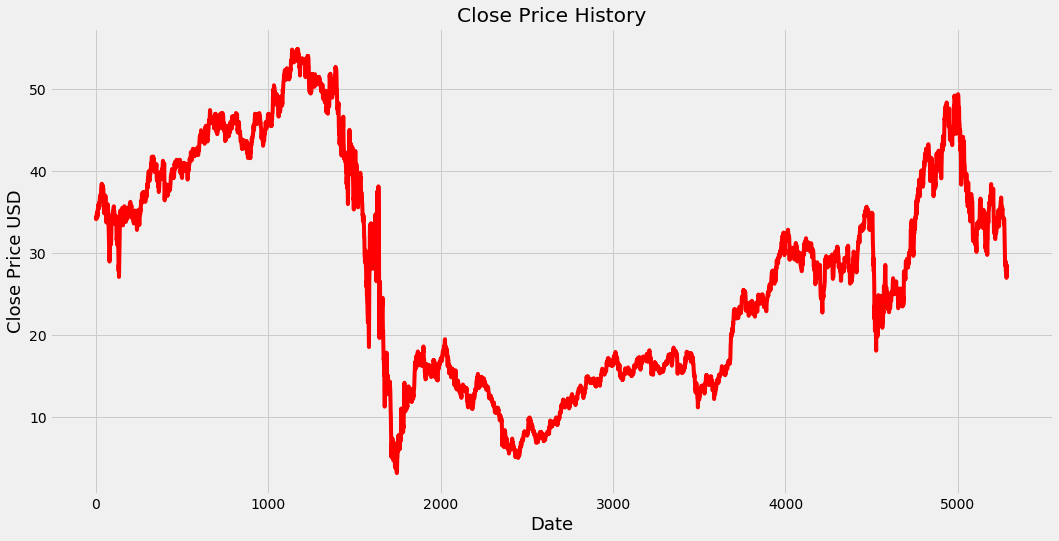

In [11]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'], color='red')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize = 18)
plt.show()

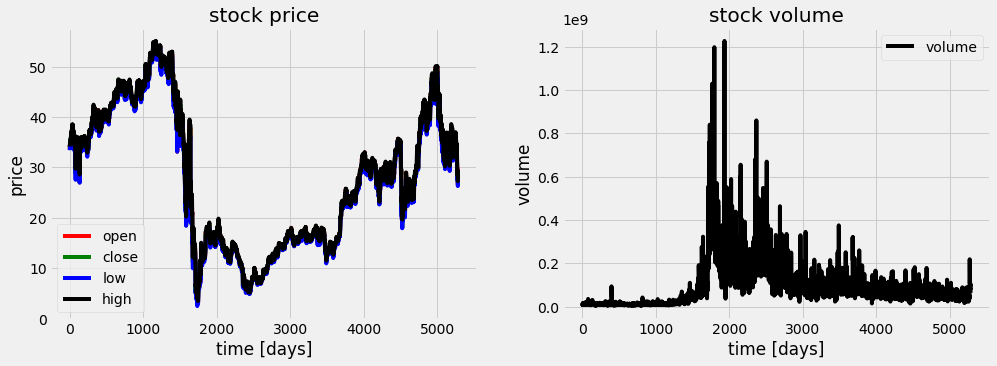

In [12]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.Open.values, color='red', label='open')
plt.plot(df.Close.values, color='green', label='close')
plt.plot(df.Low.values, color='blue', label='low')
plt.plot(df.High.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df.Volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

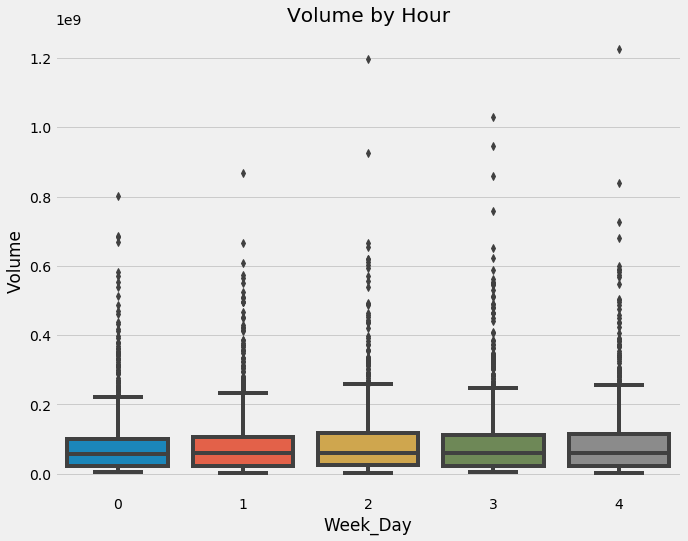

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Week_Day', y='Volume')
ax.set_title('Volume by Hour')
plt.show()

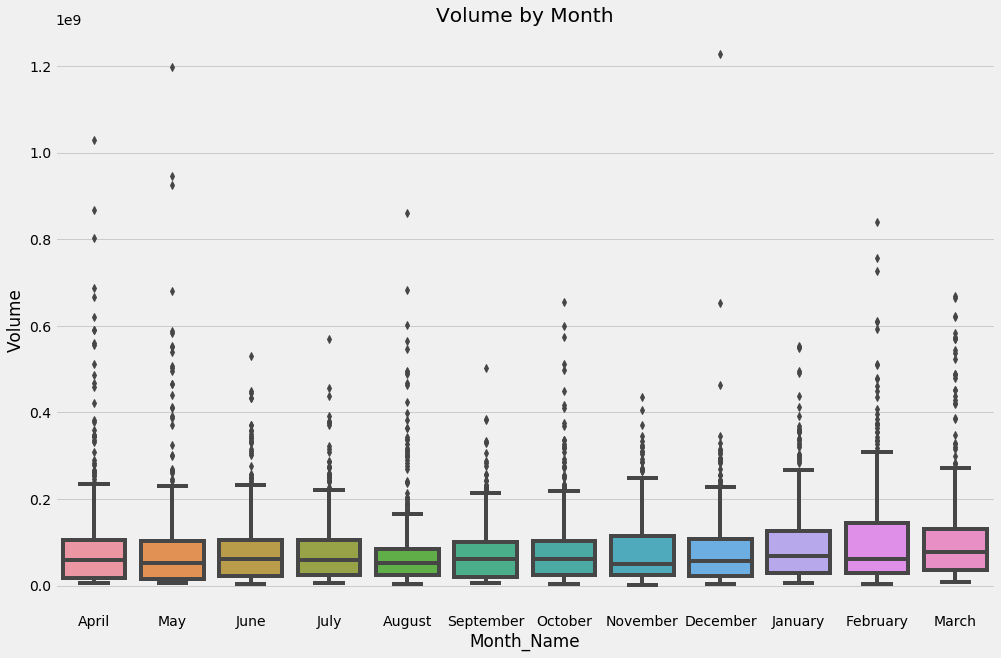

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=df, x='Month_Name', y='Volume')
ax.set_title('Volume by Month')
plt.show()

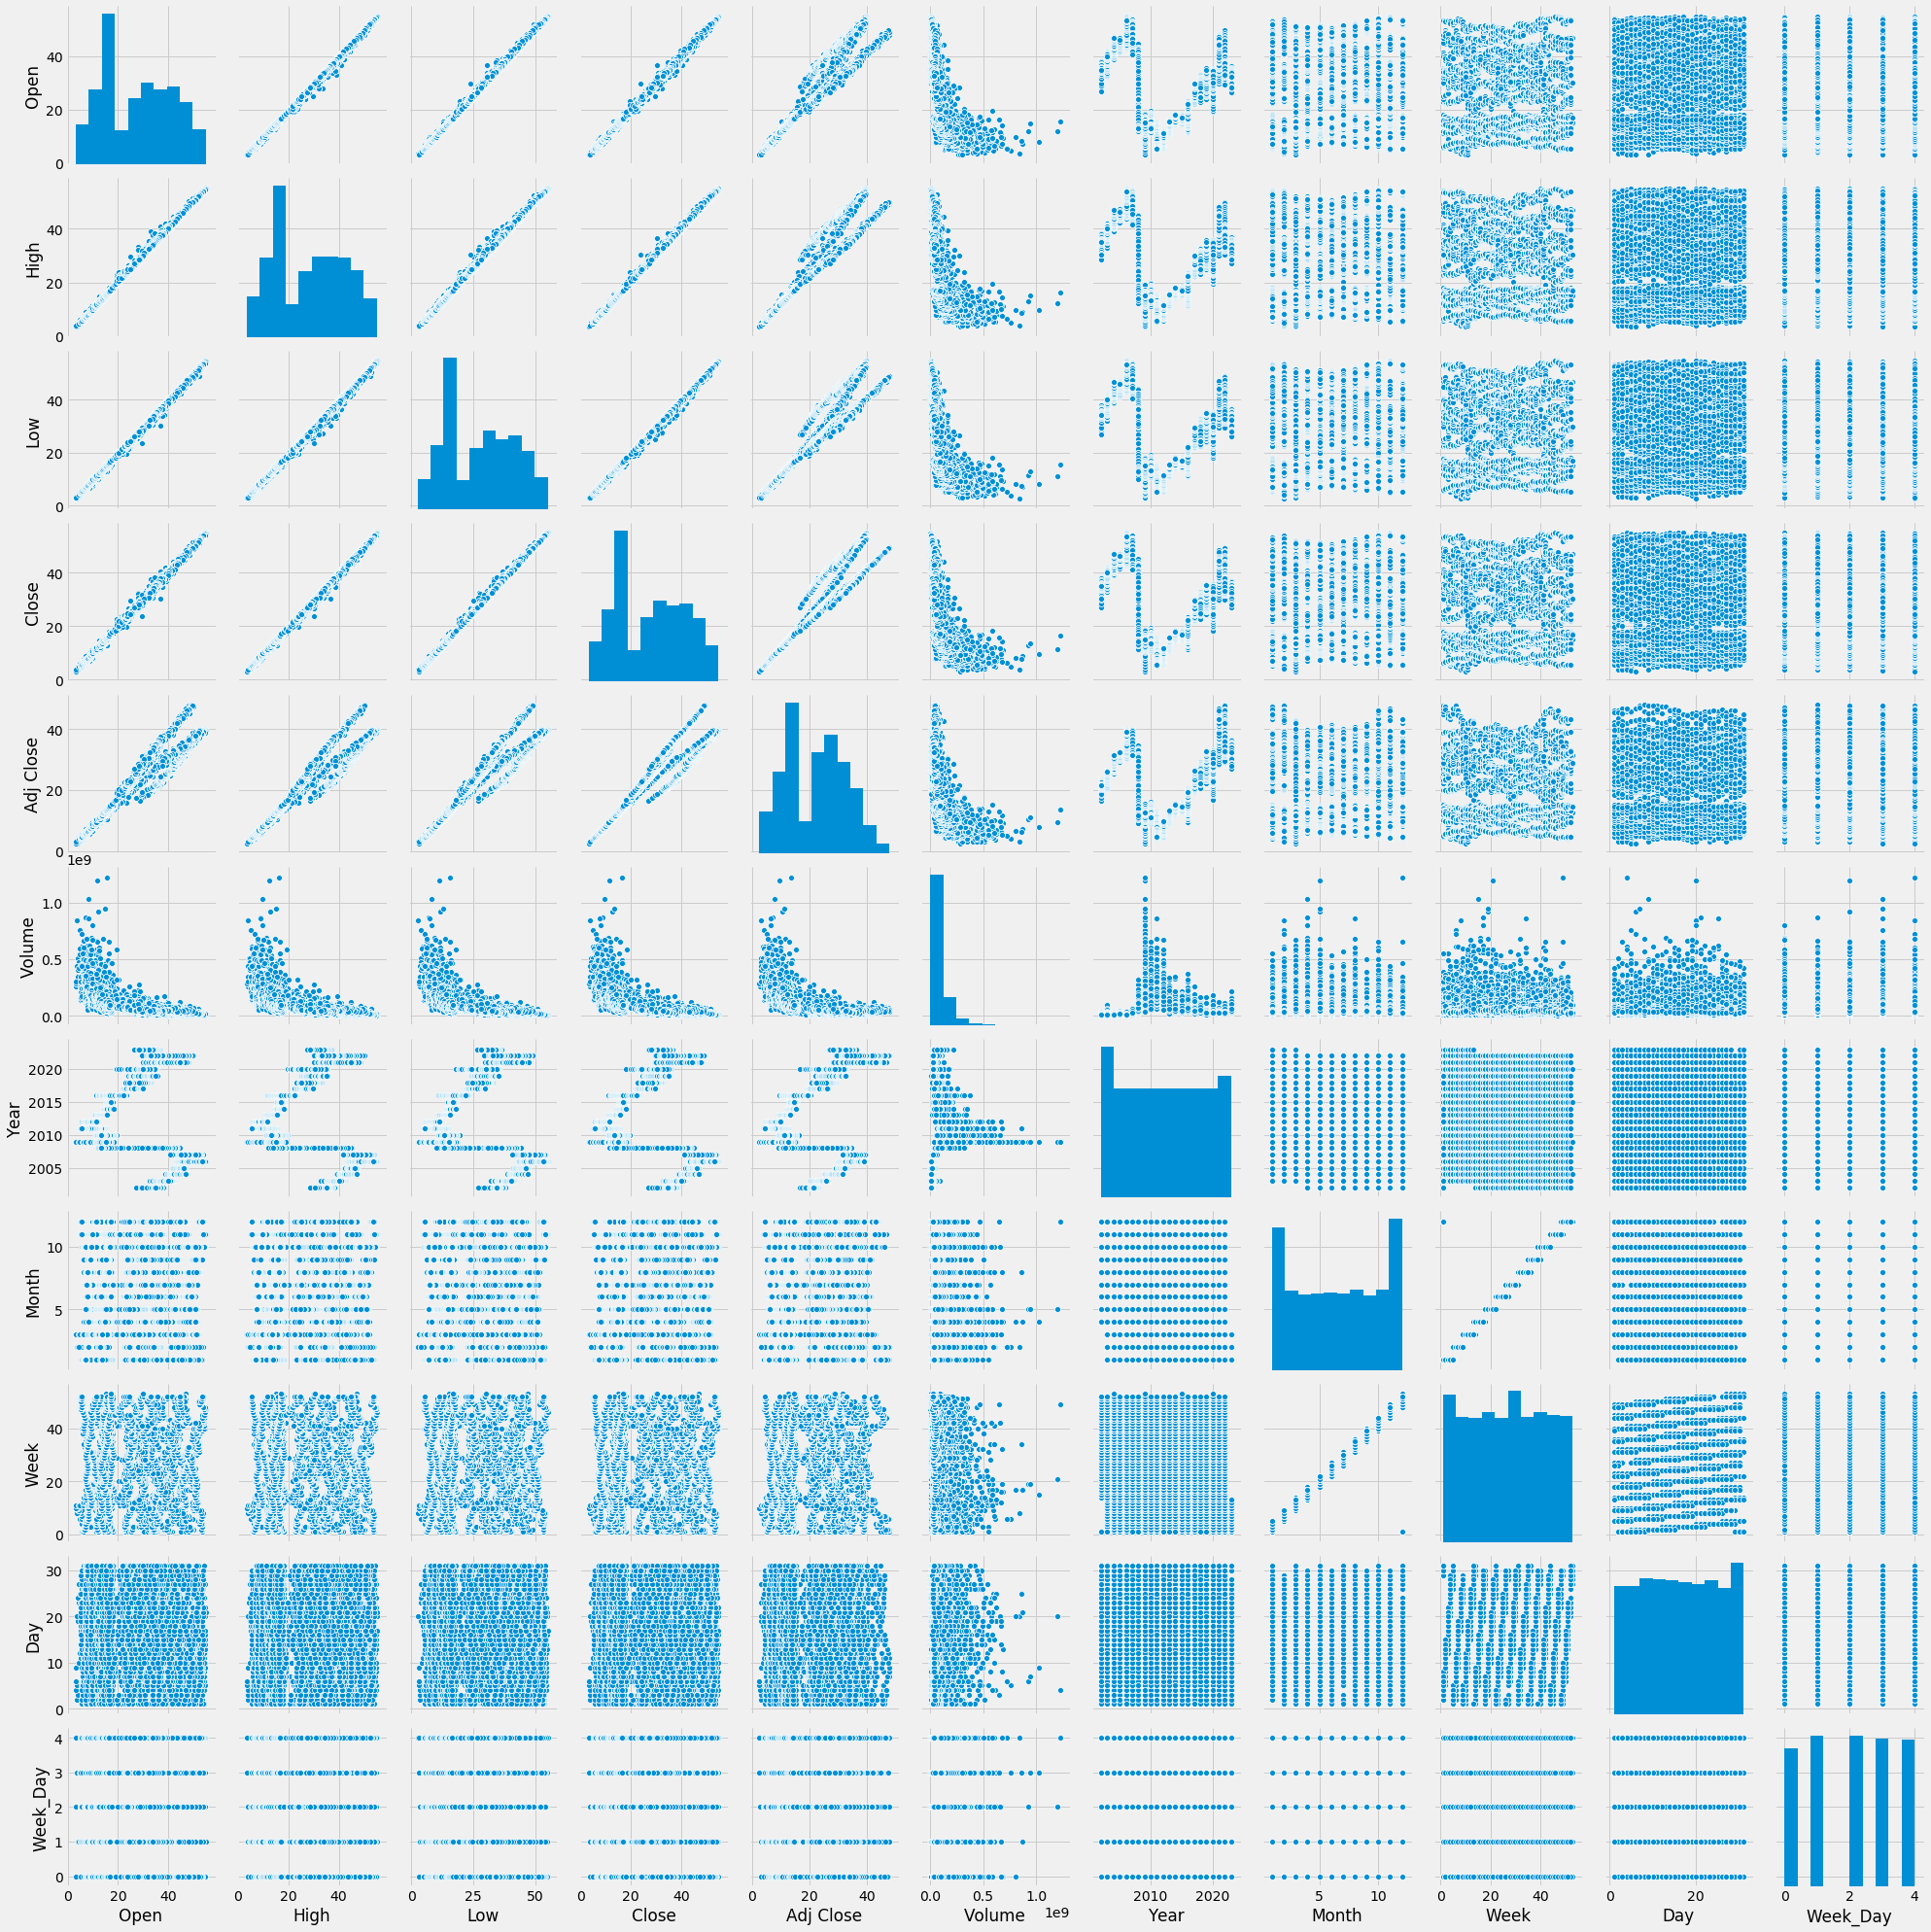

In [15]:
sns.pairplot(df)

In [16]:
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.80)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.80):int(len(df))])

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [18]:
data_training_array = scaler.fit_transform(data_training)

In [19]:
x_train = []
y_train = []

for i in range(100,data_training_array.shape[0]):
    x_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i,0])
    
    
    
x_train , y_train = np.array(x_train) , np.array(y_train)

In [23]:
x_train

array([[[0.59766228],
        [0.60345825],
        [0.59872488],
        ...,
        [0.60307185],
        [0.61649918],
        [0.60596986]],

       [[0.60345825],
        [0.59872488],
        [0.60297521],
        ...,
        [0.61649918],
        [0.60596986],
        [0.61108962]],

       [[0.59872488],
        [0.60297521],
        [0.60510042],
        ...,
        [0.60596986],
        [0.61108962],
        [0.61891418]],

       ...,

       [[0.53284385],
        [0.53323027],
        [0.53574188],
        ...,
        [0.43315298],
        [0.432187  ],
        [0.43701698]],

       [[0.53323027],
        [0.53574188],
        [0.53863986],
        ...,
        [0.432187  ],
        [0.43701698],
        [0.43643739]],

       [[0.53574188],
        [0.53863986],
        [0.53786706],
        ...,
        [0.43701698],
        [0.43643739],
        [0.44223339]]])

In [ ]:
from keras.layers import Dense , Dropout , LSTM
from keras.models import Sequential

In [ ]:
model = Sequential()

model.add(LSTM(units = 50 , activation='relu', return_sequences=True , input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 60 , activation='relu', return_sequences=True , ))
model.add(Dropout(0.3))
model.add(LSTM(units = 80 , activation='relu', return_sequences=True , ))
model.add(Dropout(0.4))
model.add(LSTM(units = 120 , activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam' , loss = 'mean_squared_error')

In [ ]:
import keras
import keras.utils
from keras import utils as np_utils
early_stopping_ = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 

In [ ]:
model.fit(x_train,y_train , epochs=25 ,
                                batch_size=64, callbacks=[early_stopping_] , verbose=1)

In [ ]:
past_100_days = data_training.tail(100)

In [ ]:
final_df = past_100_days.append(data_testing , ignore_index = True)

In [ ]:
input_data = scaler.fit_transform(final_df)

In [ ]:
x_test = []
y_test = []

for i in range(100,input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i,0])
    
    
    
x_test , y_test = np.array(x_test) , np.array(y_test)

In [ ]:
y_predicted = model.predict(x_test)

In [ ]:
scaler.scale_

In [ ]:
scale_factor =  1 / 0.03194888

y_predicted = y_predicted  * scale_factor
y_test = y_test * scale_factor

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test , 'b' , label = 'orginal price' )
plt.plot(y_predicted , 'r' , label = 'predicted price')
plt.xlabel('Time')
plt.ylabel('price')
plt.legend()
plt.show()